In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import plotly
plotly.__version__

'1.12.6'

In [24]:
import plotly.plotly as py
import plotly.graph_objs as go

In [7]:
import numpy as np
import scipy.stats as st
import scipy.interpolate as si
import pandas as pd
import seaborn as sns

import os
import sys
import itertools

In [342]:
%load_ext watermark

In [344]:
%watermark -a "David Avakian" -d -v -m -p numpy,scipy,pandas,seaborn -g

David Avakian 2016-08-14 

CPython 3.5.2
IPython 4.1.2

numpy 1.10.4
scipy 0.17.0
pandas 0.18.0
seaborn 0.7.0

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 3.13.0-85-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 


### First Taste of Plotly

In [9]:
trace0 = go.Scatter(
    x=[1, 2, 3, 4],
    y=[10, 15, 13, 17]
)
trace1 = go.Scatter(
    x=[1, 2, 3, 4],
    y=[16, 5, 11, 9]
)
data = go.Data([trace0, trace1])

In [10]:
py.iplot(data, filename = 'basic-line')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~david_avakian/0 or inside your plot.ly account where it is named 'basic-line'


### Try Plotting a Dirichlet Distribution

In [11]:
alpha = np.array([5, 5, 5])
rv = st.dirichlet(alpha)

In [12]:
coord_step = 0.01
coord_range = np.arange(coord_step, 1, coord_step)

xv, yv = np.meshgrid(coord_range, coord_range)

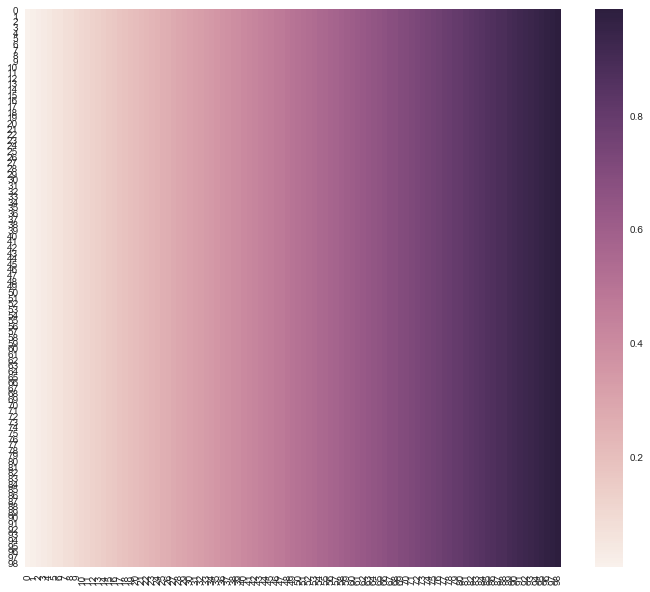

In [13]:
figure(figsize=(12, 10))
sns.heatmap(xv)

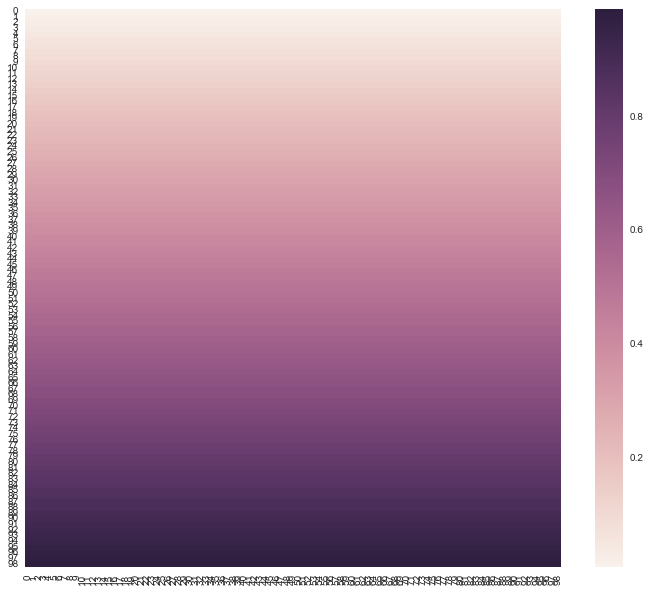

In [14]:
figure(figsize=(12, 10))
sns.heatmap(yv)

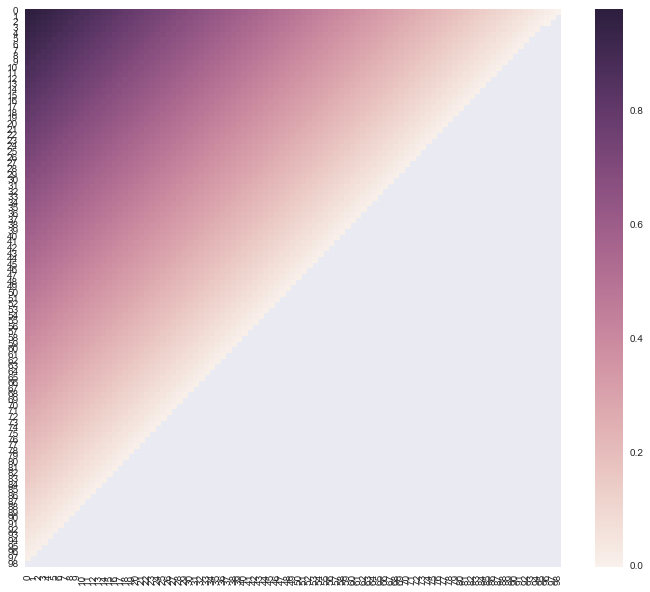

In [15]:
zv = 1.0 - xv - yv
zv = np.where(zv > 0.0, zv, np.nan)

figure(figsize=(12, 10))
sns.heatmap(zv)

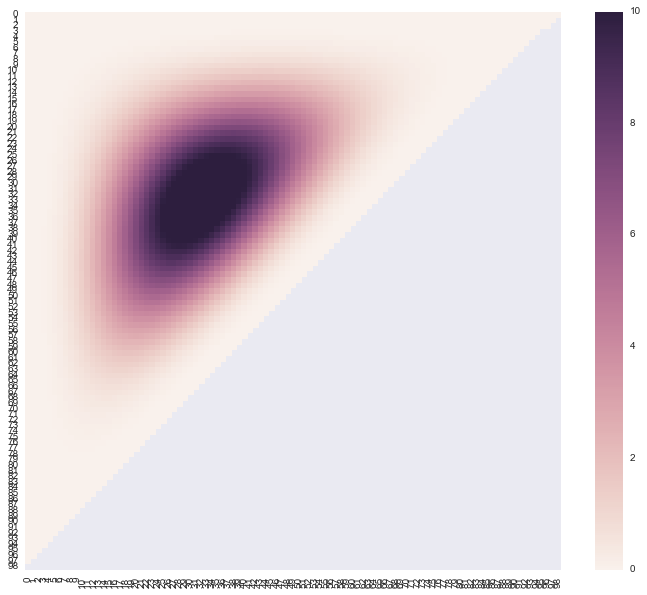

In [16]:
dv = rv.pdf(np.array((xv, yv, zv)))

figure(figsize=(12, 10))
sns.heatmap(dv, vmin=0, vmax=10)

In [17]:
pd.Series(dv.flatten()).describe()

count    4.854000e+03
mean     2.060157e+00
std      3.012339e+00
min      3.428597e-70
25%      1.995353e-02
50%      4.613402e-01
75%      2.994276e+00
max      1.185228e+01
dtype: float64

In [41]:
text = [["pdf: %.2f" % d for d in dv[i]] for i in range(dv.shape[0])]
len(text), len(text[0])

(99, 99)

In [44]:
data = [
    go.Surface(
        x=xv,
        y=yv,
        z=zv,
        surfacecolor=dv,
        hoverinfo="x+y+z+text",
        text=text,
        name="Dirichlet(%.2f, %.2f, %.2f)" % tuple(alpha)
    )
]

layout = go.Layout(
    title='Dirichlet Demo',
    autosize=False,
    width=800,
    height=600,
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='dirichlet_demo')


### Make an Interactive 3D Plot with Parameter Selection

In [338]:
def generate_dirichlet_surface(alpha, coord_step=0.01, visible=False, max_pdf=20):
    """
    Generate a plotly 3D surface for standard simplex at granularity coord_step, with colors
    mapped to Dirichlet(alpha) pdf values. Filter out pts with pdf values exceeding max_pdf.
    """
    
    rv = st.dirichlet(alpha)

    coord_range = np.arange(coord_step, 1, coord_step)
    xv, yv = np.meshgrid(coord_range, coord_range)

    zv = 1.0 - xv - yv
    zv = np.where(zv > 0.0, zv, np.nan)

    dv = rv.pdf(np.array((xv, yv, zv)))
    
    zv = np.where(dv > max_pdf, np.nan, zv)
    dv = np.where(dv > max_pdf, np.nan, dv)
    
    text = [["pdf: %.4f" % d for d in dv[i]] for i in range(dv.shape[0])]
    name = "%.1f %.1f %.1f" % tuple(alpha)

    res = go.Surface(
            x=xv,
            y=yv,
            z=zv,
            surfacecolor=dv,
            cmin=0.0,
            #cmax=25.0,
            #cauto=False,
            colorscale='Viridis',
            hoverinfo="name+x+y+z+text",
            text=text,
            name=name,
            visible=visible
        )
    return res


In [339]:
def generate_dirichlet_interactive_figure(alpha_range=None):
    """
    Generate a plotly 3D figure with Dirichlet distributions corresponding to a range
    of alpha parameters, selectable from drop-down menus.
    """
    
    if alpha_range is None:
        alpha_log_beg=-1
        alpha_log_end=1
        alpha_log_step=5
        alpha_log_base=2
        alpha_range = np.logspace(alpha_log_beg, alpha_log_end, alpha_log_step, base=alpha_log_base)
    
    n_range = len(alpha_range)
    n = n_range ** 3
    
    alphas = []
    sfcs = []
    
    visible=True
    visibility = np.eye(n).astype(bool)
    
    group_indices = [[], []]
    
    for group_1 in [True, False]:
        for alpha_x in alpha_range:
            for alpha_y in alpha_range:
                for alpha_z in alpha_range:

                    all_over_1 = alpha_x >= 1 and alpha_y >= 1 and alpha_z >= 1
                    non_decreasing = alpha_x <= alpha_y <= alpha_z
                    
                    if (all_over_1 and group_1) or ((not all_over_1) and non_decreasing and (not group_1)):
                        
                        group_indices[int(all_over_1)].append(len(alphas))

                        alpha = np.array([alpha_x, alpha_y, alpha_z])
                        alphas.append(alpha)

                        print("Generating surface for alpha: %s (group %d)" % (alpha, group_1))
                        sfc = generate_dirichlet_surface(alpha, coord_step=0.01, visible=visible)
                        sfcs.append(sfc)

                        visible=False
                
    data = go.Data(sfcs)

    print("Generating layout & figure")
    layout = go.Layout(
        title='Dirichlet Distribution Interactive Plot',
        legend={'xanchor': 'right'},
        autosize=True,
        width=800,
        height=800,
        #scene={'bgcolor': 'rgb(217, 217, 217)'},
        updatemenus=[
            dict(
                x=0,
                y=1.0 + k_group * 0.1,
                yanchor='top',
                font={'size': 10, 'family': 'courier'},
                buttons=[
                    dict(
                        args=['visible', list(visibility[i])],
                        label='alpha=(%.1f %.1f %.1f)' % tuple(alphas[i]),
                        method='restyle'
                    )
                    for i in group_indices[k_group]]
            )
            for k_group in [0, 1]
        ],
    )
    
    fig = go.Figure(data=data, layout=layout)
    return fig


In [340]:
fig = generate_dirichlet_interactive_figure(alpha_range=np.array([2, 1, 0.9]))

Generating surface for alpha: [ 2.  2.  2.] (group 1)
Generating surface for alpha: [ 2.  2.  1.] (group 1)
Generating surface for alpha: [ 2.  1.  2.] (group 1)
Generating surface for alpha: [ 2.  1.  1.] (group 1)
Generating surface for alpha: [ 1.  2.  2.] (group 1)
Generating surface for alpha: [ 1.  2.  1.] (group 1)
Generating surface for alpha: [ 1.  1.  2.] (group 1)
Generating surface for alpha: [ 1.  1.  1.] (group 1)
Generating surface for alpha: [ 0.9  2.   2. ] (group 0)
Generating surface for alpha: [ 0.9  1.   2. ] (group 0)
Generating surface for alpha: [ 0.9  1.   1. ] (group 0)
Generating surface for alpha: [ 0.9  0.9  2. ] (group 0)
Generating surface for alpha: [ 0.9  0.9  1. ] (group 0)
Generating surface for alpha: [ 0.9  0.9  0.9] (group 0)
Generating layout & figure


In [341]:
py.iplot(fig, filename='dirichlet_interactive')